# Generate Rotation Data

## Load patients' ROI data

In [1]:
ROI_CT_path = '../Resources/ROI_CT.xlsx'
ROI_MR_path = '../Resources/ROI_MR.xlsx'

In [2]:
import pandas as pd

roi_CT = pd.read_excel(ROI_CT_path, index_col=[0, 1], header=[0, 1])

print(roi_CT)


              Bridget           Chris           Jean-Marc           Median  \
                    X    Y    Z     X    Y    Z         X    Y    Z      X   
AH LLSCC ant      758  449  207   758  449  207       757  448  207    758   
   LLSCC post     751  478  205   751  478  205       751  479  207    751   
   RLSCC ant      243  475  214   243  475  214       243  473  214    243   
   RLSCC post     256  502  208   256  502  208       256  501  209    256   
AZ LLSCC ant      797  524  247   797  524  247       795  524  246    797   
...               ...  ...  ...   ...  ...  ...       ...  ...  ...    ...   
PH RLSCC post     235  512  216   235  512  216       236  511  217    235   
SM LLSCC ant      771  564  209   771  564  209       769  562  210    771   
   LLSCC post     754  584  199   754  584  199       753  582  199    754   
   RLSCC ant      233  524  256   233  524  256       235  523  255    233   
   RLSCC post     248  544  239   248  544  239       248  544  

In [3]:
roi_CT_AH = roi_CT.loc['AH']
print(roi_CT_AH)

roi_CT_AH_Median = roi_CT_AH.Median

roi_CT_AH_Median.values

           Bridget           Chris           Jean-Marc           Median  ...  \
                 X    Y    Z     X    Y    Z         X    Y    Z      X  ...   
LLSCC ant      758  449  207   758  449  207       757  448  207    758  ...   
LLSCC post     751  478  205   751  478  205       751  479  207    751  ...   
RLSCC ant      243  475  214   243  475  214       243  473  214    243  ...   
RLSCC post     256  502  208   256  502  208       256  501  209    256  ...   

                Bridget-Diff       Chris-Diff       JM-Diff        
              Z            X  Y  Z          X  Y  Z       X  Y  Z  
LLSCC ant   207            0  0  0          0  0  0       1  1  0  
LLSCC post  205            0  0  0          0  0  0       0 -1 -2  
RLSCC ant   214            0  0  0          0  0  0       0  2  0  
RLSCC post  208            0  0  0          0  0  0       0  1 -1  

[4 rows x 21 columns]


array([[758, 449, 207],
       [751, 478, 205],
       [243, 475, 214],
       [256, 502, 208]])

## Load patients' DICOM data: CT/MR

In [4]:
dicom_AH_CT_path = '/Volumes/ExternalDis/PhD/Project/Date/CT_MRI_Pre_Post_A/AH Pre'

print(dicom_AH_CT_path)

/Volumes/ExternalDis/PhD/Project/Date/CT_MRI_Pre_Post_A/AH Pre


### Present ROI and DICOM

In [58]:
import pydicom as dicom
import os
import numpy
from matplotlib import pyplot
from matplotlib.patches import Circle

In [6]:
lstFilesDCM = []  # create an empty list
for dirName, subdirList, fileList in os.walk(dicom_AH_CT_path):
    for filename in fileList:
        if ".dcm" in filename.lower():  # check whether the file's DICOM
            lstFilesDCM.append(os.path.join(dirName,filename))

print(lstFilesDCM)

['/Volumes/ExternalDis/PhD/Project/Date/CT_MRI_Pre_Post_A/AH Pre/ser011img00000.dcm', '/Volumes/ExternalDis/PhD/Project/Date/CT_MRI_Pre_Post_A/AH Pre/ser011img00001.dcm', '/Volumes/ExternalDis/PhD/Project/Date/CT_MRI_Pre_Post_A/AH Pre/ser011img00002.dcm', '/Volumes/ExternalDis/PhD/Project/Date/CT_MRI_Pre_Post_A/AH Pre/ser011img00003.dcm', '/Volumes/ExternalDis/PhD/Project/Date/CT_MRI_Pre_Post_A/AH Pre/ser011img00004.dcm', '/Volumes/ExternalDis/PhD/Project/Date/CT_MRI_Pre_Post_A/AH Pre/ser011img00005.dcm', '/Volumes/ExternalDis/PhD/Project/Date/CT_MRI_Pre_Post_A/AH Pre/ser011img00006.dcm', '/Volumes/ExternalDis/PhD/Project/Date/CT_MRI_Pre_Post_A/AH Pre/ser011img00007.dcm', '/Volumes/ExternalDis/PhD/Project/Date/CT_MRI_Pre_Post_A/AH Pre/ser011img00008.dcm', '/Volumes/ExternalDis/PhD/Project/Date/CT_MRI_Pre_Post_A/AH Pre/ser011img00009.dcm', '/Volumes/ExternalDis/PhD/Project/Date/CT_MRI_Pre_Post_A/AH Pre/ser011img00010.dcm', '/Volumes/ExternalDis/PhD/Project/Date/CT_MRI_Pre_Post_A/AH Pre/

In [7]:
# Get ref file
RefDs = dicom.read_file(lstFilesDCM[0])
print(RefDs)
print("####################################")

# Load dimensions based on the number of rows, columns, and slices (along the Z axis)
ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns), len(lstFilesDCM))
print(ConstPixelDims)
print("####################################")

# Load spacing values (in mm)
ConstPixelSpacing = (float(RefDs.PixelSpacing[0]), float(RefDs.PixelSpacing[1]), float(RefDs.SliceThickness))
print(ConstPixelSpacing)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 78
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Big Endian
(0002, 0012) Implementation Class UID            UI: 1.2.840.113619.6.201
(0002, 0013) Implementation Version Name         SH: 'CENTRICITY_3.0'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 192'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0012) Instance Creation Date              DA: '20191115'
(0008, 0013) Instance Creation Time              TM: '121000'
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.76.380.18.15.1180824113221050.3530.92.1
(0008, 0020) Study Date                          DA: '20191115'
(0008, 0021) Series Date                         DA: '20191115'
(0008, 0022) Acquisition Date                    DA: 

In [104]:
x = numpy.arange(0.0, ConstPixelDims[0]*ConstPixelSpacing[0], ConstPixelSpacing[0])
y = numpy.arange(0.0, ConstPixelDims[1]*ConstPixelSpacing[1], ConstPixelSpacing[1])
z = numpy.arange(0.0, ConstPixelDims[2]*ConstPixelSpacing[2], ConstPixelSpacing[2])

print(x)
print(x.shape)
print("#########")
print(y)
print(y.shape)
print("#########")
print(z)
print(z.shape)

[0.0000e+00 1.5000e-01 3.0000e-01 ... 1.5255e+02 1.5270e+02 1.5285e+02]
(1020,)
#########
[0.0000e+00 1.5000e-01 3.0000e-01 ... 1.5255e+02 1.5270e+02 1.5285e+02]
(1020,)
#########
[ 0.    0.15  0.3   0.45  0.6   0.75  0.9   1.05  1.2   1.35  1.5   1.65
  1.8   1.95  2.1   2.25  2.4   2.55  2.7   2.85  3.    3.15  3.3   3.45
  3.6   3.75  3.9   4.05  4.2   4.35  4.5   4.65  4.8   4.95  5.1   5.25
  5.4   5.55  5.7   5.85  6.    6.15  6.3   6.45  6.6   6.75  6.9   7.05
  7.2   7.35  7.5   7.65  7.8   7.95  8.1   8.25  8.4   8.55  8.7   8.85
  9.    9.15  9.3   9.45  9.6   9.75  9.9  10.05 10.2  10.35 10.5  10.65
 10.8  10.95 11.1  11.25 11.4  11.55 11.7  11.85 12.   12.15 12.3  12.45
 12.6  12.75 12.9  13.05 13.2  13.35 13.5  13.65 13.8  13.95 14.1  14.25
 14.4  14.55 14.7  14.85 15.   15.15 15.3  15.45 15.6  15.75 15.9  16.05
 16.2  16.35 16.5  16.65 16.8  16.95 17.1  17.25 17.4  17.55 17.7  17.85
 18.   18.15 18.3  18.45 18.6  18.75 18.9  19.05 19.2  19.35 19.5  19.65
 19.8  19.95 20.1

In [9]:
# The array is sized based on 'ConstPixelDims'
ArrayDicom = numpy.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)

# loop through all the DICOM files
for filenameDCM in lstFilesDCM:
    # read the file
    ds = dicom.read_file(filenameDCM)
    # store the raw image data
    ArrayDicom[:, :, lstFilesDCM.index(filenameDCM)] = ds.pixel_array

print(ArrayDicom)


[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]


In [27]:
ArrayDicom.shape

(1020, 1020, 336)

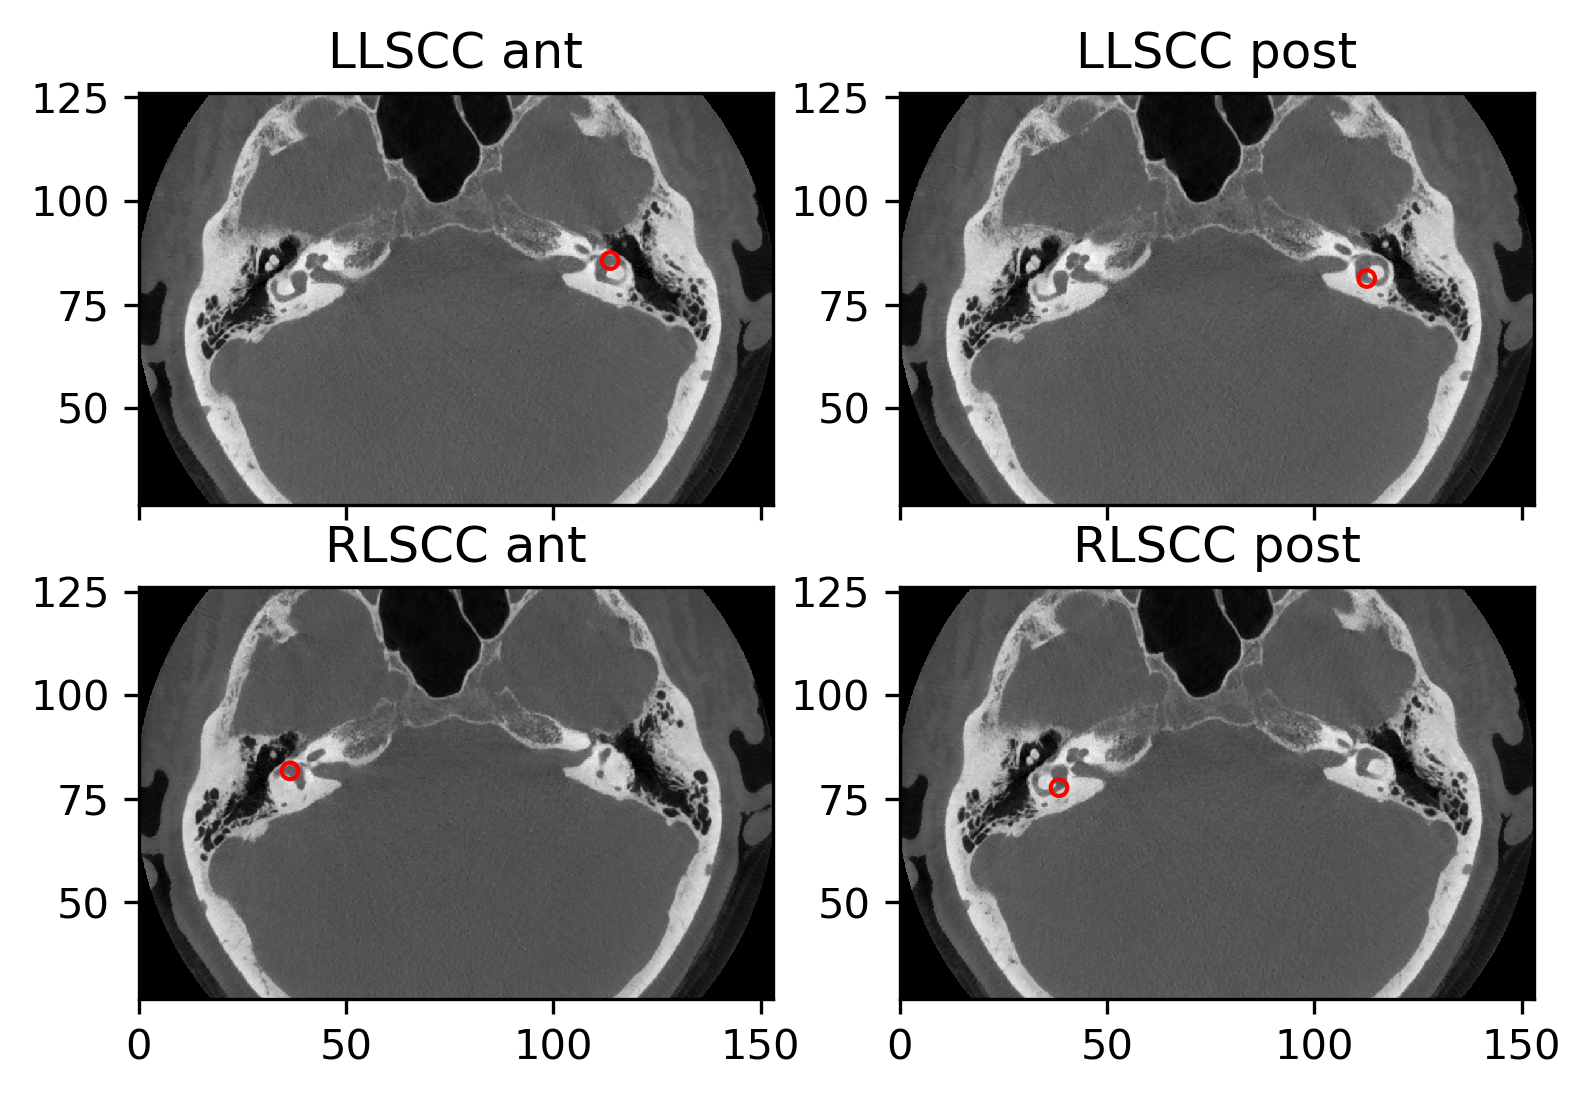

In [107]:
fig, axs = pyplot.subplots(2,2,sharex=True)
fig.set_dpi(300)

axs[0][0].set_title("LLSCC ant")
axs[0][0].set_aspect('equal', 'datalim')
axs[0][0].pcolormesh(x[:], y[:], numpy.flipud(ArrayDicom[:, :, 207]), cmap=pyplot.gray())
LLSCC_ant = Circle((758*0.15, (1020-449)*0.15), 2, facecolor='None', edgecolor='r', lw=1)
axs[0][0].add_patch(LLSCC_ant)

axs[0][1].set_title("LLSCC post")
axs[0][1].set_aspect('equal', 'datalim')
axs[0][1].pcolormesh(x[:], y[:], numpy.flipud(ArrayDicom[:, :, 205]), cmap=pyplot.gray())
LLSCC_post = Circle((751*0.15, (1020-478)*0.15), 2, facecolor='None', edgecolor='r', lw=1)
axs[0][1].add_patch(LLSCC_post)

axs[1][0].set_title("RLSCC ant")
axs[1][0].set_aspect('equal', 'datalim')
axs[1][0].pcolormesh(x[:], y[:], numpy.flipud(ArrayDicom[:, :, 214]), cmap=pyplot.gray())
RLSCC_ant = Circle((243*0.15, (1020-475)*0.15), 2, facecolor='None', edgecolor='r', lw=1)
axs[1][0].add_patch(RLSCC_ant)

axs[1][1].set_title("RLSCC post")
axs[1][1].set_aspect('equal', 'datalim')
axs[1][1].pcolormesh(x[:], y[:], numpy.flipud(ArrayDicom[:, :, 208]), cmap=pyplot.gray())
RLSCC_post = Circle((256*0.15, (1020-502)*0.15), 2, facecolor='None', edgecolor='r', lw=1)
axs[1][1].add_patch(RLSCC_post)

pyplot.show()

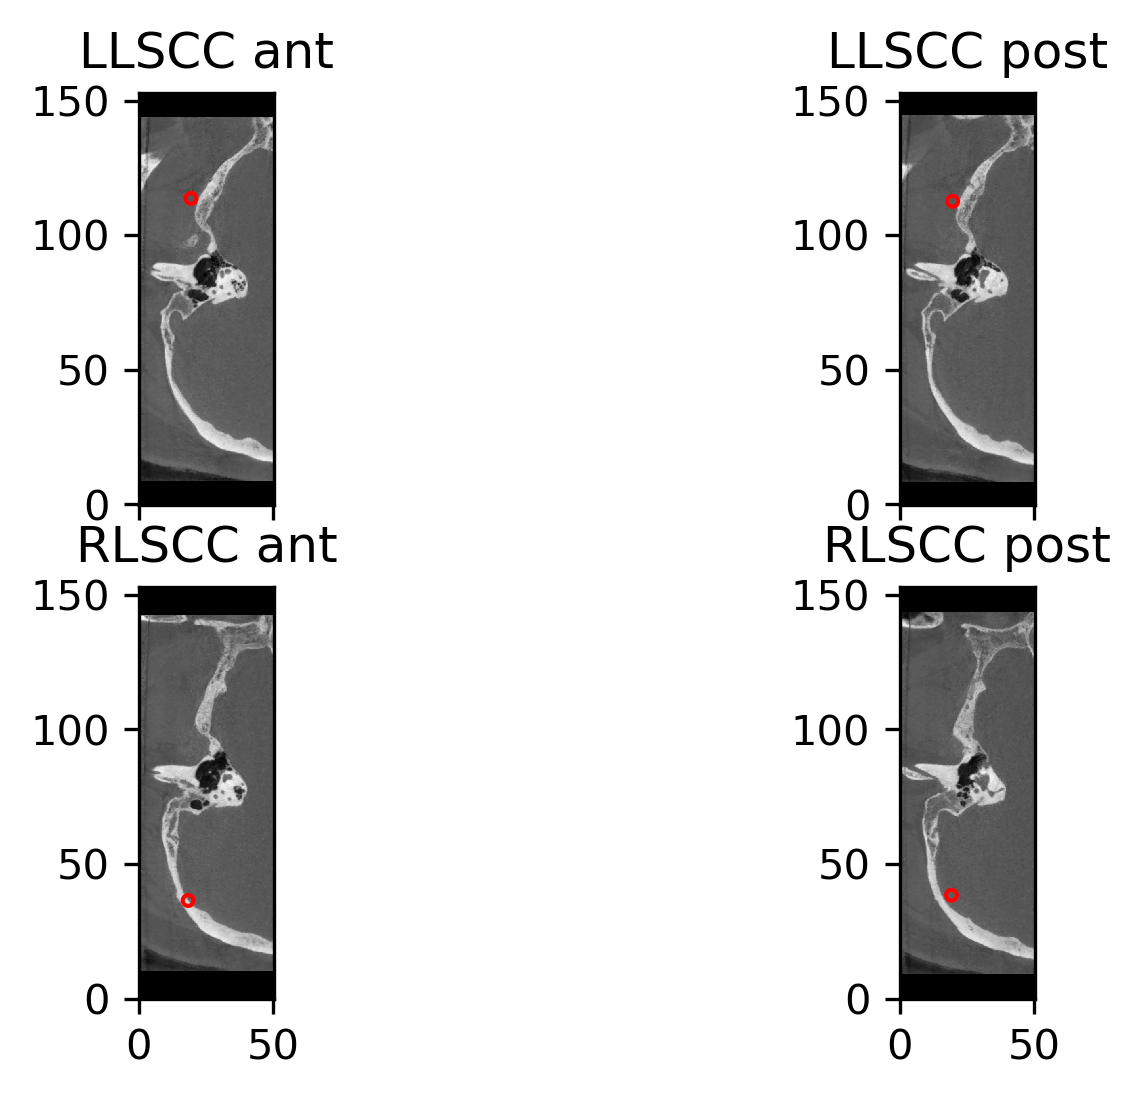

In [122]:

fig, axs = pyplot.subplots(2,2,sharex=True)
fig.set_dpi(300)

axs[0][0].set_title("LLSCC ant")
axs[0][0].set_aspect('equal')
axs[0][0].pcolormesh(z[:], x[:], numpy.flipud(ArrayDicom[:, 758, :]), cmap=pyplot.gray())
LLSCC_ant = Circle(((336-207)*0.15, 758*0.15), 2, facecolor='None', edgecolor='r', lw=1)
axs[0][0].add_patch(LLSCC_ant)

axs[0][1].set_title("LLSCC post")
axs[0][1].set_aspect('equal')
axs[0][1].pcolormesh(z[:], x[:], numpy.flipud(ArrayDicom[:, 751, :]), cmap=pyplot.gray())
LLSCC_post = Circle(((336-205)*0.15, 751*0.15), 2, facecolor='None', edgecolor='r', lw=1)
axs[0][1].add_patch(LLSCC_post)

axs[1][0].set_title("RLSCC ant")
axs[1][0].set_aspect('equal')
axs[1][0].pcolormesh(z[:], x[:], numpy.flipud(ArrayDicom[:, 243, :]), cmap=pyplot.gray())
RLSCC_ant = Circle(((336-214)*0.15, 243*0.15), 2, facecolor='None', edgecolor='r', lw=1)
axs[1][0].add_patch(RLSCC_ant)

axs[1][1].set_title("RLSCC post")
axs[1][1].set_aspect('equal')
axs[1][1].pcolormesh(z[:], x[:], numpy.flipud(ArrayDicom[:, 256, :]), cmap=pyplot.gray())
RLSCC_post = Circle(((336-208)*0.15, 256*0.15), 2, facecolor='None', edgecolor='r', lw=1)
axs[1][1].add_patch(RLSCC_post)

pyplot.show()

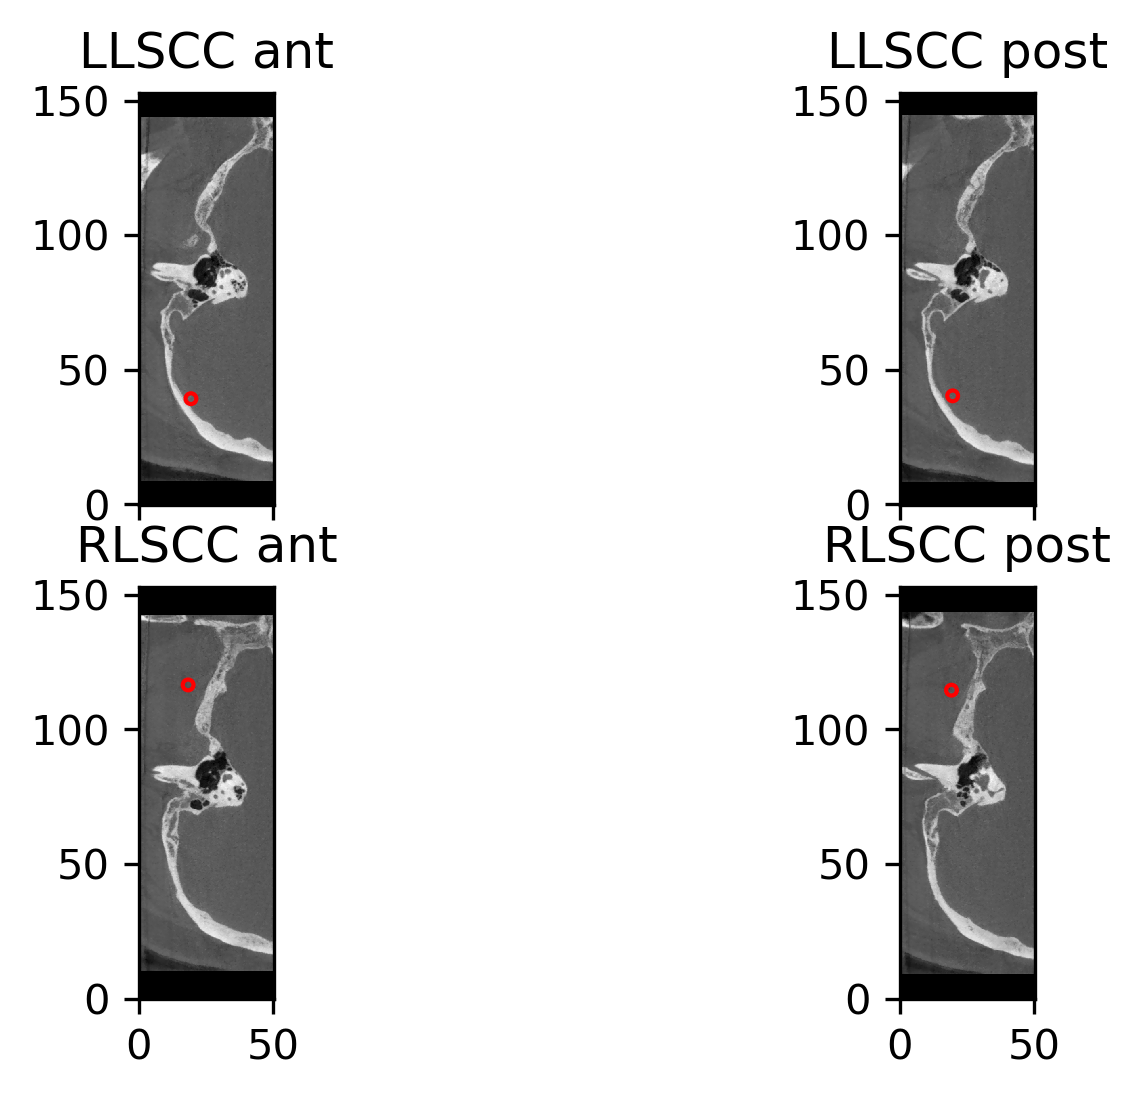

In [123]:
fig, axs = pyplot.subplots(2,2,sharex=True)
fig.set_dpi(300)

axs[0][0].set_title("LLSCC ant")
axs[0][0].set_aspect('equal')
axs[0][0].pcolormesh(z[:], x[:], numpy.flipud(ArrayDicom[:, 758, :]), cmap=pyplot.gray())
LLSCC_ant = Circle(((336-207)*0.15, (1020-758)*0.15), 2, facecolor='None', edgecolor='r', lw=1)
axs[0][0].add_patch(LLSCC_ant)

axs[0][1].set_title("LLSCC post")
axs[0][1].set_aspect('equal')
axs[0][1].pcolormesh(z[:], x[:], numpy.flipud(ArrayDicom[:, 751, :]), cmap=pyplot.gray())
LLSCC_post = Circle(((336-205)*0.15, (1020-751)*0.15), 2, facecolor='None', edgecolor='r', lw=1)
axs[0][1].add_patch(LLSCC_post)

axs[1][0].set_title("RLSCC ant")
axs[1][0].set_aspect('equal')
axs[1][0].pcolormesh(z[:], x[:], numpy.flipud(ArrayDicom[:, 243, :]), cmap=pyplot.gray())
RLSCC_ant = Circle(((336-214)*0.15, (1020-243)*0.15), 2, facecolor='None', edgecolor='r', lw=1)
axs[1][0].add_patch(RLSCC_ant)

axs[1][1].set_title("RLSCC post")
axs[1][1].set_aspect('equal')
axs[1][1].pcolormesh(z[:], x[:], numpy.flipud(ArrayDicom[:, 256, :]), cmap=pyplot.gray())
RLSCC_post = Circle(((336-208)*0.15, (1020-256)*0.15), 2, facecolor='None', edgecolor='r', lw=1)
axs[1][1].add_patch(RLSCC_post)

pyplot.show()

## Augment DICOM data: Rotate and Translate

In [128]:
import numpy as np
import random
import scipy
import scipy.ndimage

In [156]:
def random_rotation_3d(batch, max_angle):
    """ Randomly rotate an image by a random angle (-max_angle, max_angle).

    Arguments:
    max_angle: `float`. The maximum rotation angle.

    Returns:
    batch of rotated 3D images
    """
    #size = batch.shape
    batch = np.squeeze(batch)
    #batch_rot = np.zeros(batch.shape)
    #for i in range(batch.shape[0]):
    #    if bool(random.getrandbits(1)):
            #image1 = np.squeeze(batch[i])
    image1 = np.squeeze(batch)
            # rotate along z-axis
    angle_z = random.uniform(-max_angle, max_angle)
    image2 = scipy.ndimage.interpolation.rotate(image1, angle_z, mode='nearest', axes=(0, 1))

            # rotate along y-axis
    angle_y = random.uniform(-max_angle, max_angle)
    image3 = scipy.ndimage.interpolation.rotate(image2, angle_y, mode='nearest', axes=(0, 2))

            # rotate along x-axis
    angle_x = random.uniform(-max_angle, max_angle)
    rot_img = scipy.ndimage.interpolation.rotate(image3, angle_x, mode='nearest', axes=(1, 2))

    return rot_img, [angle_x, angle_y, angle_z]

In [157]:
import numpy as np
import math

def rotation_matrix(axis, theta):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    """
    axis = np.asarray(axis)
    axis = axis / math.sqrt(np.dot(axis, axis))
    a = math.cos(theta / 2.0)
    b, c, d = -axis * math.sin(theta / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

In [159]:
batch_rot, angles = random_rotation_3d(ArrayDicom, 15)

KeyboardInterrupt: 

In [161]:
print(batch_rot.shape)
print(angles)


(1111, 1159, 767)
[-12.732130279049624, 11.748867055873621, -2.605337862179862]


In [164]:
roi = roi_CT_AH_Median.values
print(roi)

theta_x = angles[0]*math.pi/180
axis_x = [1,0,0]
rot_matrix_x = rotation_matrix(axis_x, theta_x)

theta_y = angles[1]*math.pi/180
axis_y = [0,1,0]
rot_matrix_y = rotation_matrix(axis_y, theta_y)

theta_z = angles[2]*math.pi/180
axis_z = [0,0,1]
rot_matrix_z = rotation_matrix(axis_z, theta_z)

roi_rot_z = np.dot(rot_matrix_z, [758,449,207])
roi_rot_y = np.dot(rot_matrix_y, roi_rot_z)
roi_ort_x = np.dot(rot_matrix_x, roi_rot_y)

print(roi_ort_x)

[[758 449 207]
 [751 478 205]
 [243 475 214]
 [256 502 208]]
[803.48442953 413.66649875 -48.0291507 ]


### Present augmented data

In [165]:
pixel_dim_rot = batch_rot.shape
pixel_space_rot = 0.15

x_r = numpy.arange(0.0, pixel_dim_rot[0]*pixel_space_rot, pixel_space_rot)
y_r = numpy.arange(0.0, pixel_dim_rot[1]*pixel_space_rot, pixel_space_rot)
z_r = numpy.arange(0.0, pixel_dim_rot[2]*pixel_space_rot, pixel_space_rot)

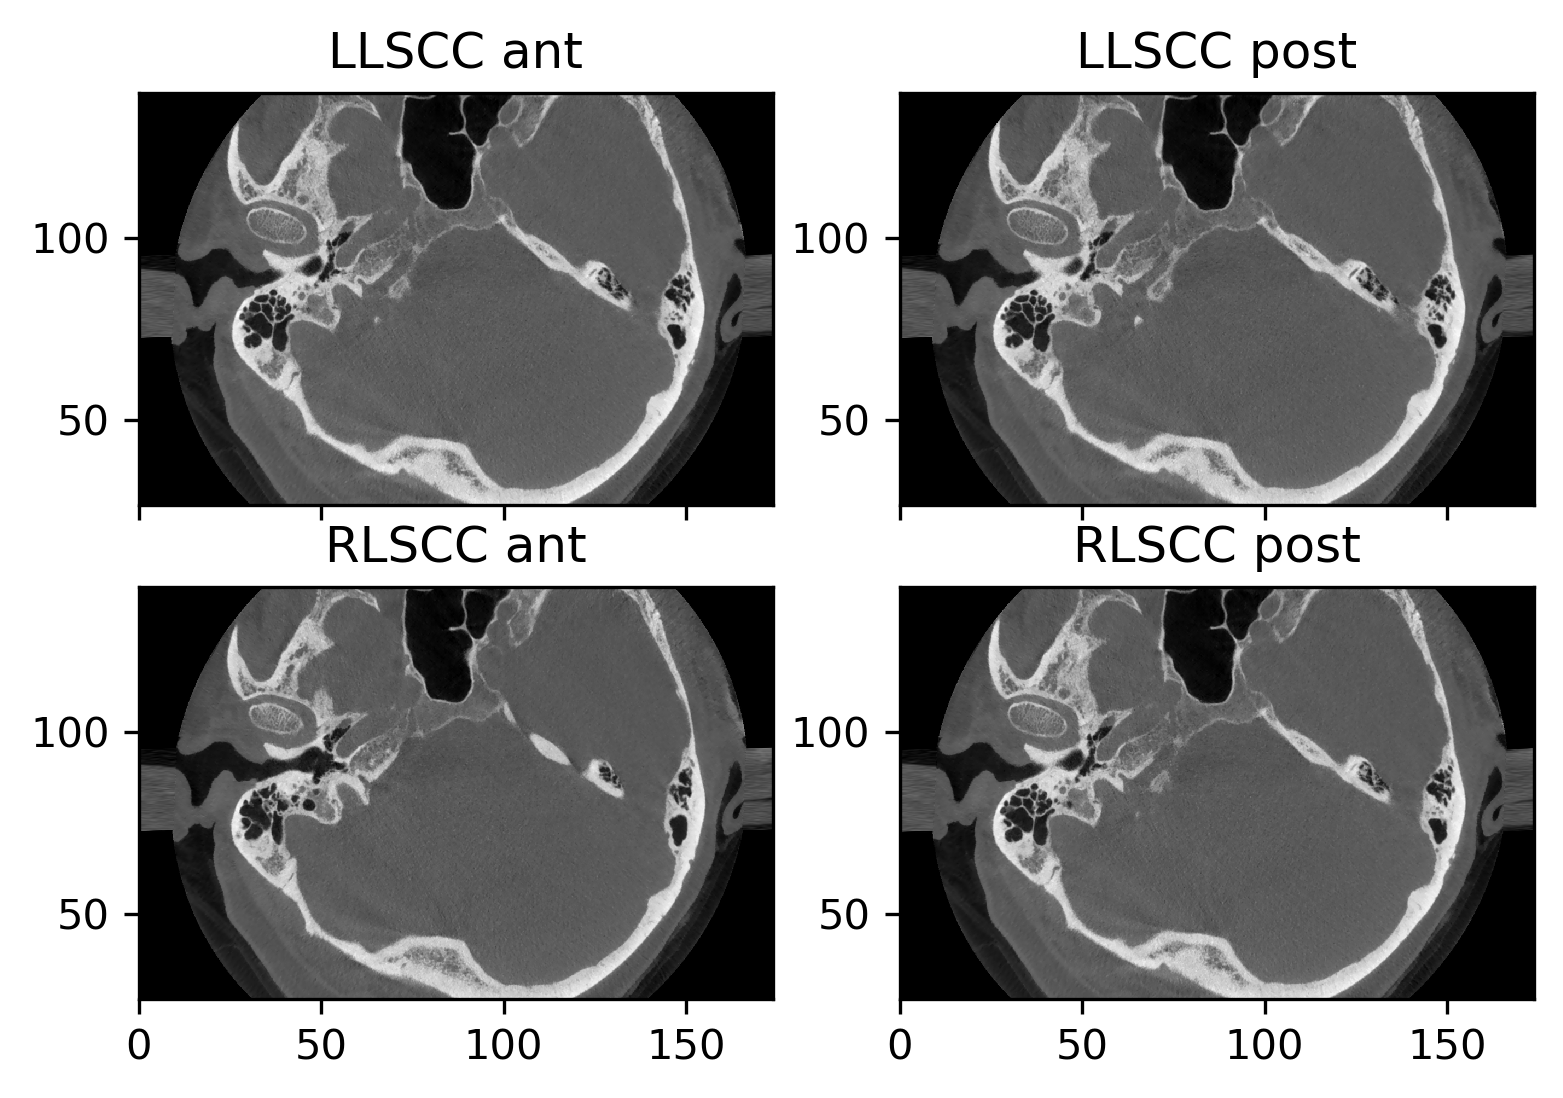

In [166]:
fig, axs = pyplot.subplots(2,2,sharex=True)
fig.set_dpi(300)

axs[0][0].set_title("LLSCC ant")
axs[0][0].set_aspect('equal', 'datalim')
axs[0][0].pcolormesh(y_r[:], x_r[:], numpy.flipud(batch_rot[:, :, 407]), cmap=pyplot.gray())
#LLSCC_ant = Circle((758*0.15, (1020-449)*0.15), 2, facecolor='None', edgecolor='r', lw=1)
#axs[0][0].add_patch(LLSCC_ant)

axs[0][1].set_title("LLSCC post")
axs[0][1].set_aspect('equal', 'datalim')
axs[0][1].pcolormesh(y_r[:], x_r[:], numpy.flipud(batch_rot[:, :, 405]), cmap=pyplot.gray())
#LLSCC_post = Circle((751*0.15, (1020-478)*0.15), 2, facecolor='None', edgecolor='r', lw=1)
#axs[0][1].add_patch(LLSCC_post)

axs[1][0].set_title("RLSCC ant")
axs[1][0].set_aspect('equal', 'datalim')
axs[1][0].pcolormesh(y_r[:], x_r[:], numpy.flipud(batch_rot[:, :, 414]), cmap=pyplot.gray())
#RLSCC_ant = Circle((243*0.15, (1020-475)*0.15), 2, facecolor='None', edgecolor='r', lw=1)
#axs[1][0].add_patch(RLSCC_ant)

axs[1][1].set_title("RLSCC post")
axs[1][1].set_aspect('equal', 'datalim')
axs[1][1].pcolormesh(y_r[:], x_r[:], numpy.flipud(batch_rot[:, :, 408]), cmap=pyplot.gray())
#RLSCC_post = Circle((256*0.15, (1020-502)*0.15), 2, facecolor='None', edgecolor='r', lw=1)
#axs[1][1].add_patch(RLSCC_post)

pyplot.show()